# Modeling 2016 US Presidential Elections

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 4 columns, representing Clinton, Trump, Johnson, and Stein in that order. In the example below, Clinton got 340 votes in the first survey, Trump got 258, Johnson got 27, and Stein got 13.
```
  >>> survey_results['Indiana']
  array([[340, 258,  27,  13],
         [240, 155,   5,   5],
         [235, 155,  50,  20],
         [308, 266,  49,  35],
         [222, 161,  80,  30]])
```
Data from [Wikipedia: Statewide opinion polling for the United States presidential election, 2016](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_United_States_presidential_election,_2016)


In [2]:
electoral_votes = {
    'California': 55, 'Texas': 38, 'Florida': 29, 'New York': 29, 'Illinois': 20,
    'Pennsylvania': 20, 'Ohio': 18, 'Georgia': 16, 'Michigan': 16,
    'North Carolina': 15, 'New Jersey': 14, 'Virginia': 13, 'Washington': 12,
    'Arizona': 11, 'Indiana': 11, 'Massachusetts': 11, 'Tennessee': 11,
    'Maryland': 10, 'Minnesota': 10, 'Missouri': 10, 'Wisconsin': 10, 'Alabama': 9,
    'Colorado': 9, 'South Carolina': 9, 'Kentucky': 8, 'Louisiana': 8,
    'Connecticut': 7, 'Oklahoma': 7, 'Oregon': 7, 'Arkansas': 6, 'Iowa': 6,
    'Kansas': 6, 'Mississippi': 6, 'Nevada': 6, 'Utah': 6, 'Nebraska': 5,
    'New Mexico': 5, 'West Virginia': 5, 'Hawaii': 4, 'Idaho': 4, 'Maine': 4,
    'New Hampshire': 4, 'Rhode Island': 4, 'Alaska': 3, 'Delaware': 3,
    'District of Columbia': 3, 'Montana': 3, 'North Dakota': 3, 'South Dakota': 3,
    'Vermont': 3, 'Wyoming': 3}

survey_results = {
    'Alabama': np.array([], dtype=int).reshape(0, 4),
    'Alaska': np.array([400 * np.array([.47, .43, .07, .03]), 500 * np.array([.36, .37, .07, .03]), 500 * np.array([.34, .37, .10, .02]), 660 * np.array([.31, .36, .18, .06])], dtype=int),
    'Arizona': np.array([392 * np.array([.45, .47, .05, .02]), 550 * np.array([.39, .47, .04, .03]), 719 * np.array([.40, .45, .09, .03]), 769 * np.array([.44, .49, .05, .01]), 2229 * np.array([.45, .44, .07, .01]), 700 * np.array([.43, .47, .02, .02]), 550 * np.array([.41, .45, .03, .01]), 994 * np.array([.42, .44, .04, .01]), 550 * np.array([.40, .42, .05, .02]), 2385 * np.array([.48, .46, .05, .01]), 401 * np.array([.45, .46, .04, .01]), 550 * np.array([.41, .41, .05, .02]), 1538 * np.array([.39, .44, .06, .02]), 713 * np.array([.43, .38, .06, .01]), 400 * np.array([.39, .37, .08, .03]), 600 * np.array([.44, .42, .09, .01]), 718 * np.array([.42, .42, .05, .01]), 484 * np.array([.41, .46, .09, .01]), 649 * np.array([.38, .40, .12, .03])], dtype=int),
    'Arkansas': np.array([463 * np.array([.33, .56, .04, .02]), 831 * np.array([.34, .55, .03, .01]), 600 * np.array([.29, .57, .05, .03])], dtype=int),
    'California': np.array([401 * np.array([.58, .35, .03, .02]), 747 * np.array([.56, .35, .04, .01]), 1365 * np.array([.54, .30, .04, .03]), 1498 * np.array([.53, .33, .04, .03]), 1704 * np.array([.54, .28, .05, .05]), 725 * np.array([.56, .30, .04, .02]), 1250 * np.array([.54, .30, .04, .03]), 622 * np.array([.61, .25, .04, .03]), 732 * np.array([.59, .33, .03, .02]), 1055 * np.array([.47, .31, .10, .05]), 515 * np.array([.62, .34, .02, .01]), 1426 * np.array([.50, .33, .05, .06]), 678 * np.array([.57, .32, .03, .01]), 4212 * np.array([.49, .29, .11, .06])], dtype=int),
    'Colorado': np.array([1150 * np.array([.45, .44, .05, .04]), 500 * np.array([.44, .38, .07, .02]), 550 * np.array([.39, .39, .05, .04]), 750 * np.array([.44, .41, .08, .04]), 685 * np.array([.45, .37, .10, .03]), 400 * np.array([.49, .38, .07, .03]), 602 * np.array([.44, .33, .10, .03]), 694 * np.array([.46, .40, .06, .02]), 784 * np.array([.41, .42, .13, .03]), 991 * np.array([.40, .39, .07, .02]), 644 * np.array([.44, .42, .10, .02]), 540 * np.array([.41, .34, .12, .03]), 600 * np.array([.38, .42, .13, .02]), 704 * np.array([.48, .43, .04, .02]), 605 * np.array([.43, .38, .07, .02]), 997 * np.array([.42, .39, .07, .02])], dtype=int),
    'Connecticut': np.array([1000 * np.array([.50 , .35 , .09 , .04])], dtype=int),
    'Delaware': np.array([762 * np.array([.51 , .30 , .07 , .02])], dtype=int),
    'District of Columbia': np.array([], dtype=int).reshape(0, 4),
    'Florida': np.array([1100 * np.array([.46, .50, .02, .01]), 884 * np.array([.46, .45, .02, .01]), 1188 * np.array([.45, .45, .04, .02]), 603 * np.array([.49, .45, .03, .01]), 773 * np.array([.49, .47, .03, .01]), 626 * np.array([.46, .45, .02, .02]), 1995 * np.array([.49, .46, .02, .01]), 1150 * np.array([.45, .49, .02, .01]), 718 * np.array([.48, .40, .03, .02]), 500 * np.array([.46, .45, .04, .00]), 814 * np.array([.42, .46, .04, .02]), 779 * np.array([.45, .44, .05, .02]), 698 * np.array([.42, .46, .02, .01]), 1028 * np.array([.50, .37, .05, .01]), 836 * np.array([.43, .39, .06, .03]), 953 * np.array([.43, .45, .04, .02]), 1251 * np.array([.48, .45, .02, .01]), 500 * np.array([.46, .43, .03, .02]), 1042 * np.array([.46, .43, .03, .02]), 538 * np.array([.49, .45, .03, .02]), 507 * np.array([.46, .42, .05, .01]), 660 * np.array([.48, .44, .04, .01]), 985 * np.array([.46, .42, .05, .01]), 1532 * np.array([.42, .38, .06, .02]), 533 * np.array([.47, .44, .05, .01]), 400 * np.array([.49, .43, .01, .00]), 700 * np.array([.45, .42, .05, .03]), 600 * np.array([.44, .45, .04, .03]), 696 * np.array([.41, .38, .06, .03]), 545 * np.array([.46, .41, .05, .02]), 619 * np.array([.47, .46, .04, .02]), 820 * np.array([.46, .42, .07, .01]), 826 * np.array([.45, .43, .03, .01]), 500 * np.array([.44, .45, .03, .01]), 400 * np.array([.46, .41, .06, .01]), 502 * np.array([.49, .44, .06, .02]), 867 * np.array([.41, .40, .09, .02]), 788 * np.array([.44, .47, .06, .01]), 1193 * np.array([.44, .42, .05, .02]), 781 * np.array([.42, .46, .03, .01]), 744 * np.array([.43, .44, .05, .01])], dtype=int),
    'Georgia': np.array([1250 * np.array([.45, .52, .02, .00]), 650 * np.array([.42, .51, .02, .03]), 600 * np.array([.39, .45, .06, .03])], dtype=int),
    'Hawaii': np.array([], dtype=int).reshape(0, 4),
    'Idaho': np.array([608 * np.array([.30 , .40 , .10 , .03])], dtype=int),
    'Illinois': np.array([500 * np.array([.53, .41, .02, .00]), 600 * np.array([.45, .34, .06, .02]), 1200 * np.array([.51, .36, .06, .02]), 664 * np.array([.50, .32, .06, .01]), 865 * np.array([.53, .28, .05, .02]), 1200 * np.array([.49, .35, .04, .01]), 700 * np.array([.45, .39, .06, .03]), 600 * np.array([.43, .30, .08, .03]), 955 * np.array([.51, .33, .04, .01])], dtype=int),
    'Indiana': np.array([1313 * np.array([.36, .44, .10, .03])], dtype=int),
    'Iowa': np.array([800 * np.array([.39 , .46 , .06 , .01]), 700 * np.array([.41 , .44 , .05 , .04]), 500 * np.array([.44 , .43 , .03 , .03]), 791 * np.array([.44 , .44 , .04 , .01]), 800 * np.array([.39 , .43 , .06 , .02]), 491 * np.array([.38 , .38 , .09 , .01]), 612 * np.array([.37 , .44 , .10 , .02]), 404 * np.array([.37 , .45 , .08 , .02]), 1054 * np.array([.39 , .40 , .10 , .03]), 1076 * np.array([.41 , .44 , .05 , .02])], dtype=int),
    'Kansas': np.array([624 * np.array([.38 , .49 , .07 , .01]), 581 * np.array([.36 , .47 , .07 , .02]), 595 * np.array([.36 , .48 , .08 , .02])], dtype=int),
    'Kentucky': np.array([602 * np.array([.37 , .54 , .01 , .01]), 602 * np.array([.37 , .54 , .01 , .01])], dtype=int),
    'Louisiana': np.array([603 * np.array([.35 , .49 , .07 , .02]), 625 * np.array([.34 , .54 , .02 , .01]), 800 * np.array([.38 , .45 , .04 , .01]), 905 * np.array([.35 , .45 , .06 , .02])], dtype=int),
    'Maine': np.array([855 * np.array([.45 , .39 , .07 , .04]), 750 * np.array([.46 , .42 , .12 , .02]), 812 * np.array([.42 , .37 , .09 , .04]), 670 * np.array([.48 , .37 , .05 , .03]), 890 * np.array([.42 , .36 , .09 , .04]), 892 * np.array([.44 , .36 , .09 , .03]), 513 * np.array([.40 , .36 , .12 , .03]), 835 * np.array([.37 , .37 , .11 , .05]), 779 * np.array([.42 , .39 , .09 , .05]), 800 * np.array([.44 , .35 , .12 , .02])], dtype=int),
    'Maryland': np.array([706 * np.array([.63, .27, .04, .02]), 514 * np.array([.58, .25, .06, .02])], dtype=int),
    'Massachusetts': np.array([417 * np.array([.56, .26, .08, .03]), 500 * np.array([.57, .25, .04, .03]), 502 * np.array([.54, .28, .07, .03]), 403 * np.array([.58, .26, .07, .04]), 700 * np.array([.47, .34, .09, .03]), 500 * np.array([.54, .28, .09, .04]), 500 * np.array([.50, .33, .09, .02])], dtype=int),
    'Michigan': np.array([1200 * np.array([.47, .49, .03, .01]), 957 * np.array([.46, .41, .06, .02]), 573 * np.array([.44, .44, .04, .03]), 1007 * np.array([.46, .41, .07, .03]), 600 * np.array([.42, .38, .05, .02]), 1150 * np.array([.47, .44, .04, .03]), 887 * np.array([.47, .44, .04, .03]), 737 * np.array([.50, .43, .04, .01]), 953 * np.array([.47, .41, .06, .02]), 500 * np.array([.45, .44, .05, .02]), 746 * np.array([.47, .28, .11, .04]), 500 * np.array([.50, .43, .03, .03]), 1030 * np.array([.48, .42, .05, .01]), 600 * np.array([.41, .34, .09, .03]), 1241 * np.array([.49, .41, .03, .01]), 600 * np.array([.41, .36, .07, .03]), 1102 * np.array([.51, .38, .06, .02]), 1370 * np.array([.40, .36, .07, .02]), 1429 * np.array([.47, .37, .07, .04]), 600 * np.array([.42, .31, .10, .05]), 600 * np.array([.43, .32, .10, .03]), 600 * np.array([.42, .35, .09, .03]), 1956 * np.array([.46, .41, .08, .01]), 600 * np.array([.38, .35, .10, .04]), 940 * np.array([.45, .39, .07, .01])], dtype=int),
    'Minnesota': np.array([656 * np.array([.49, .39, .05, .02]), 625 * np.array([.46, .39, .06, .02]), 625 * np.array([.44, .38, .06, .02]), 625 * np.array([.47, .39, .06, .01])], dtype=int),
    'Mississippi': np.array([], dtype=int).reshape(0, 4),
    'Missouri': np.array([750 * np.array([.41, .47, .07, .02]), 871 * np.array([.37, .50, .04, .02]), 1722 * np.array([.39, .51, .04, .01]), 508 * np.array([.38, .47, .03, .01]), 650 * np.array([.37, .52, .05, .02]), 405 * np.array([.38, .52, .04, .02]), 625 * np.array([.42, .47, .03, .01]), 2559 * np.array([.39, .50, .04, .01]), 600 * np.array([.39, .47, .05, .02]), 2171 * np.array([.42, .47, .04, .01]), 406 * np.array([.41, .46, .05, .02]), 1087 * np.array([.37, .46, .05, .02]), 600 * np.array([.34, .47, .07, .06]), 1275 * np.array([.38, .47, .08, .03])], dtype=int),
    'Montana': np.array([590 * np.array([.27 , .43 , .07 , .02])], dtype=int),
    'Nebraska': np.array([700 * np.array([.29 , .56 , .07 , .01])], dtype=int),
    'Nevada': np.array([387 * np.array([.46 , .46 , .05 , .01]), 1158 * np.array([.45 , .43 , .04 , .03]), 600 * np.array([.47 , .46 , .04 , .01]), 1100 * np.array([.45 , .50 , .03 , .01]), 550 * np.array([.44 , .42 , .03 , .00]), 700 * np.array([.43 , .43 , .09 , .04]), 400 * np.array([.42 , .42 , .07 , .03]), 627 * np.array([.41 , .42 , .08 , .03])], dtype=int),
    'New Hampshire': np.array([701 * np.array([.49 , .38 , .06 , .01]), 1000 * np.array([.45 , .44 , .05 , .03]), 600 * np.array([.43 , .48 , .04 , .01]), 500 * np.array([.42 , .42 , .05 , .02]), 695 * np.array([.44 , .44 , .05 , .02]), 500 * np.array([.39 , .40 , .10 , .03]), 641 * np.array([.46 , .39 , .06 , .01]), 600 * np.array([.46 , .43 , .06 , .02]), 401 * np.array([.46 , .42 , .07 , .01]), 768 * np.array([.45 , .36 , .10 , .04]), 772 * np.array([.43 , .38 , .08 , .03]), 900 * np.array([.44 , .36 , .10 , .06]), 770 * np.array([.49 , .34 , .08 , .02]), 501 * np.array([.41 , .38 , .11 , .03]), 517 * np.array([.45 , .39 , .09 , .02]), 500 * np.array([.44 , .42 , .05 , .01]), 502 * np.array([.42 , .35 , .13 , .04]), 600 * np.array([.43 , .37 , .11 , .04]), 522 * np.array([.46 , .42 , .06 , .01]), 400 * np.array([.47 , .38 , .10 , .01]), 737 * np.array([.39 , .37 , .15 , .03]), 600 * np.array([.42 , .37 , .14 , .04]), 408 * np.array([.43 , .45 , .04 , .02])], dtype=int),
    'New Jersey': np.array([678 * np.array([.51, .40, .03, .01]), 293 * np.array([.49, .35, .06, .04]), 735 * np.array([.50, .29, .06, .04]), 800 * np.array([.47, .43, .05, .02])], dtype=int),
    'New Mexico': np.array([8439 * np.array([.46 , .44 , .06 , .01]), 504 * np.array([.45 , .40 , .11 , .03]), 1102 * np.array([.46 , .43 , .07 , .01]), 1899 * np.array([.45 , .40 , .09 , .02]), 1536 * np.array([.46 , .36 , .12 , .02]), 594 * np.array([.46 , .33 , .14 , .02]), 501 * np.array([.35 , .31 , .24 , .02])], dtype=int),
    'New York': np.array([617 * np.array([.51, .34, .05, .02]), 611 * np.array([.54, .30, .05, .04]), 676 * np.array([.52, .31, .07, .05]), 600 * np.array([.51, .30, .08, .03])], dtype=int),
    'North Carolina': np.array([1154 * np.array([.44, .49, .04, .00]), 992 * np.array([.48, .45, .03, .00]), 710 * np.array([.42, .41, .03, .01]), 1233 * np.array([.45, .43, .05, .01]), 600 * np.array([.46, .42, .05, .03]), 805 * np.array([.44, .43, .06, .02]), 660 * np.array([.45, .39, .09, .00]), 400 * np.array([.44, .40, .09, .03]), 644 * np.array([.43, .44, .06, .00])], dtype=int),
    'North Dakota': np.array([400 * np.array([.32 , .43 , .08 , .01])], dtype=int),
    'Ohio': np.array([900 * np.array([.39, .46, .07, .03]), 1189 * np.array([.45, .46, .03, .02]), 844 * np.array([.40, .43, .08, .03]), 589 * np.array([.41, .46, .05, .02]), 800 * np.array([.45, .45, .06, .01]), 1150 * np.array([.44, .49, .02, .01]), 624 * np.array([.45, .45, .06, .01]), 774 * np.array([.44, .48, .04, .02]), 724 * np.array([.41, .42, .09, .04]), 600 * np.array([.45, .43, .07, .02]), 1200 * np.array([.43, .39, .08, .02]), 1152 * np.array([.43, .34, .10, .03]), 997 * np.array([.46, .42, .05, .02]), 872 * np.array([.44, .43, .05, .02]), 812 * np.array([.44, .42, .05, .01]), 405 * np.array([.44, .42, .05, .01]), 800 * np.array([.44, .42, .08, .01]), 497 * np.array([.42, .47, .06, .01]), 652 * np.array([.40, .37, .08, .02]), 737 * np.array([.37, .42, .06, .02]), 400 * np.array([.39, .41, .11, .04]), 802 * np.array([.39, .44, .10, .03]), 769 * np.array([.41, .46, .08, .02]), 994 * np.array([.46, .39, .07, .02]), 500 * np.array([.45, .45, .02, .01]), 500 * np.array([.39, .42, .04, .01])], dtype=int),
    'Oklahoma': np.array([], dtype=int).reshape(0, 4),
    'Oregon': np.array([504 * np.array([.41 , .34 , .04 , .02]), 608 * np.array([.46 , .36 , .05 , .05]), 600 * np.array([.43 , .36 , .07 , .05]), 654 * np.array([.48 , .38 , .06 , .04]), 605 * np.array([.45 , .33 , .08 , .03]), 610 * np.array([.43 , .28 , .11 , .03]), 517 * np.array([.38 , .25 , .10 , .03])], dtype=int),
    'Pennsylvania': np.array([1220 * np.array([.46, .40, .07, .02]), 1300 * np.array([.47, .48, .02, .01]), 405 * np.array([.44, .40, .07, .02]), 504 * np.array([.46, .46, .02, .01]), 681 * np.array([.45, .43, .02, .02]), 403 * np.array([.48, .44, .03, .01]), 799 * np.array([.48, .44, .05, .03]), 612 * np.array([.48, .43, .03, .03]), 2606 * np.array([.47, .46, .03, .02]), 652 * np.array([.49, .38, .04, .02]), 1091 * np.array([.48, .40, .05, .02]), 550 * np.array([.48, .43, .06, .00]), 420 * np.array([.45, .39, .08, .02]), 824 * np.array([.46, .39, .06, .03]), 800 * np.array([.45, .41, .04, .04]), 1467 * np.array([.45, .38, .06, .02]), 660 * np.array([.47, .41, .06, .01]), 806 * np.array([.48, .39, .06, .04]), 1747 * np.array([.46, .39, .06, .02]), 764 * np.array([.44, .40, .04, .02]), 997 * np.array([.48, .40, .04, .02]), 709 * np.array([.49, .37, .06, .04]), 402 * np.array([.50, .40, .05, .02]), 496 * np.array([.47, .38, .05, .00]), 535 * np.array([.45, .41, .05, .02]), 886 * np.array([.45, .39, .06, .02]), 771 * np.array([.45, .44, .06, .03]), 486 * np.array([.40, .38, .08, .03]), 420 * np.array([.42, .41, .04, .03]), 500 * np.array([.45, .43, .08, .01]), 400 * np.array([.46, .38, .08, .03]), 405 * np.array([.40, .32, .14, .05])], dtype=int),
    'Rhode Island': np.array([600 * np.array([.52 , .32 , .05 , .05]), 800 * np.array([.44 , .41 , .08 , .04])], dtype=int),
    'South Carolina': np.array([475 * np.array([.38, .42, .06, .03]), 1247 * np.array([.38, .53, .03, .01])], dtype=int),
    'South Dakota': np.array([], dtype=int).reshape(0, 4),
    'Tennessee': np.array([508 * np.array([.34, .44, .07, .02]), 472 * np.array([.38, .50, .05, .01]), 1000 * np.array([.33, .44, .07, .01])], dtype=int),
    'Texas': np.array([700 * np.array([.35, .49, .05, .04]), 679 * np.array([.40, .49, .06, .02]), 980 * np.array([.39, .52, .03, .00]), 959 * np.array([.42, .45, .07, .02]), 1031 * np.array([.43, .46, .05, .01]), 1000 * np.array([.38, .41, .04, .01]), 638 * np.array([.43, .47, .03, .01]), 780 * np.array([.38, .45, .04, .01]), 502 * np.array([.32, .39, .09, .03]), 700 * np.array([.36, .42, .10, .06])], dtype=int),
    'Utah': np.array([500 * np.array([.24 , .33 , .05 , .03]), 1000 * np.array([.20 , .40 , .03 , .02]), 402 * np.array([.31 , .37 , .04 , .01]), 1424 * np.array([.29 , .35 , .03 , .01]), 823 * np.array([.24 , .32 , .04 , .01]), 700 * np.array([.24 , .27 , .05 , .00]), 750 * np.array([.28 , .30 , .05 , .01]), 951 * np.array([.20 , .37 , .07 , .01]), 403 * np.array([.28 , .34 , .09 , .01]), 500 * np.array([.26 , .26 , .14 , .01]), 820 * np.array([.25 , .34 , .13 , .01]), 818 * np.array([.25 , .30 , .05 , .01]), 605 * np.array([.24 , .39 , .13 , .00])], dtype=int),
    'Vermont': np.array([1052 * np.array([.52 , .26 , .05 , .02]), 603 * np.array([.50 , .22 , .07 , .05]), 650 * np.array([.45 , .17 , .04 , .03]), 600 * np.array([.47 , .26 , .13 , .07])], dtype=int),
    'Virginia': np.array([800 * np.array([.49, .45, .03, .01]), 1024 * np.array([.48, .42, .06, .02]), 749 * np.array([.50, .38, .04, .02]), 811 * np.array([.46, .40, .07, .01]), 1237 * np.array([.45, .37, .07, .01]), 659 * np.array([.45, .39, .08, .01]), 841 * np.array([.44, .37, .08, .01]), 878 * np.array([.45, .39, .06, .02]), 1193 * np.array([.48, .42, .03, .005]), 1238 * np.array([.48, .43, .04, .01]), 654 * np.array([.45, .38, .05, .02]), 712 * np.array([.44, .39, .05, .02]), 814 * np.array([.46, .39, .05, .01]), 834 * np.array([.45, .33, .08, .01]), 500 * np.array([.47, .38, .03, .01]), 809 * np.array([.44, .29, .11, .02]), 814 * np.array([.45, .36, .07, .01]), 892 * np.array([.42, .35, .12, .01]), 1003 * np.array([.39, .33, .15, .03]), 685 * np.array([.40, .37, .08, .01])], dtype=int),
    'Washington': np.array([681 * np.array([.50, .38, .04, .02]), 502 * np.array([.48, .31, .01, .01]), 500 * np.array([.47, .31, .10, .04]), 700 * np.array([.44, .38, .07, .05]), 505 * np.array([.44, .32, .16, .06])], dtype=int),
    'West Virginia': np.array([], dtype=int).reshape(0, 4),
    'Wisconsin': np.array([500 * np.array([.44, .38, .07, .02]), 1190 * np.array([.46, .40, .04, .03]), 400 * np.array([.48, .42, .09, .01]), 600 * np.array([.48, .43, .04, .01]), 403 * np.array([.47, .40, .06, .01]), 664 * np.array([.47, .39, .01, .03]), 878 * np.array([.44, .37, .09, .03]), 500 * np.array([.43, .35, .08, .02]), 993 * np.array([.43, .39, .04, .01]), 700 * np.array([.45, .38, .11, .02]), 677 * np.array([.41, .38, .11, .02])], dtype=int),
    'Wyoming': np.array([722 * np.array([.20 , .58 , .09 , .02]), 402 * np.array([.19 , .54 , .10 , .02])], dtype=int),
}

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 51 states with 538 electoral college votes


In [3]:
stan_code = '''
data {
    int S;  // Number of surveys
    int C;  // Number of candidates
    int survey_results[S, C];  // Number of votes for each candidate in each survey
    real cauchy_location;  // Prior hyperparameters for half-Cauchy over alpha
    real cauchy_scale;
}

parameters {
    vector<lower=0>[C] alpha;
    simplex[C] p[S];  // One probability vector for each survey
}

model {
    alpha ~ cauchy(cauchy_location, cauchy_scale);
    for (i in 1:S) {
        p[i] ~ dirichlet(alpha);
        survey_results[i] ~ multinomial(p[i]);
    }
}
'''
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a89b9d288c9c4fecf50d2e6275e90c2e NOW.


Posterior α samples and 95% confidence intervals for each state

Alabama
[[ 0.04552129  0.04159969  0.03581599  0.04365394]
 [22.02612964 24.53545759 29.07338238 20.99180703]]


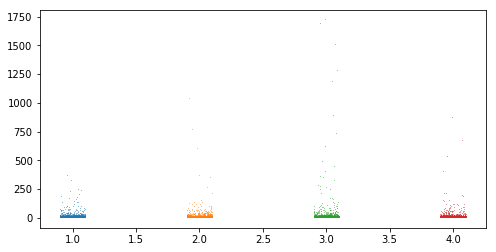

Alaska
[[ 3.10445592  3.3195319   0.96105629  0.44528596]
 [36.31680227 38.30405667 10.3917121   3.84869898]]


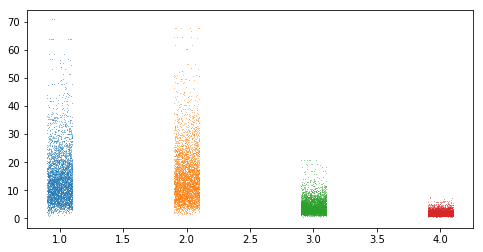

Arizona
[[ 49.06207848  51.44879017   6.55407642   1.9175871 ]
 [141.32400241 146.32183992  19.25651578   5.71397806]]


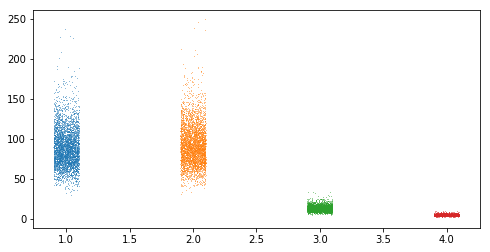

Arkansas
[[ 2.38054824  4.11534323  0.44838565  0.31734287]
 [52.26380095 91.17927265  6.92614309  3.49335928]]


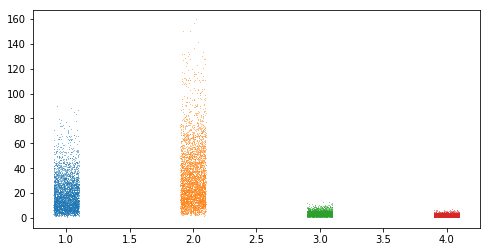

California
[[29.59305969 17.09342303  2.48676108  1.61356474]
 [87.99094145 50.46919586  7.64177378  4.92356348]]


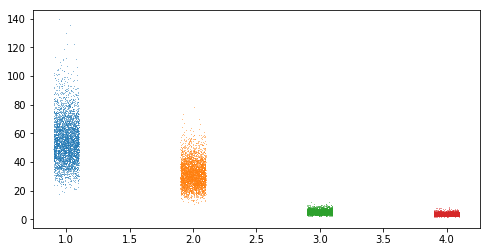

Colorado
[[ 48.08543187  43.87947667   8.69726229   3.08441528]
 [161.46554112 147.18362857  29.79416077  10.13537687]]


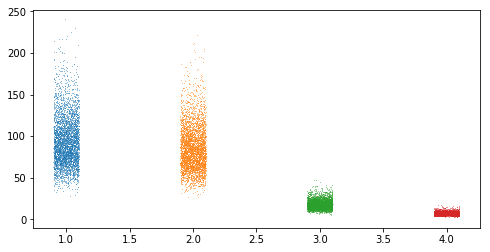

Connecticut
[[ 0.37239881  0.2891285   0.14364978  0.10290417]
 [16.60413262 10.88146385  3.67780758  2.3237785 ]]


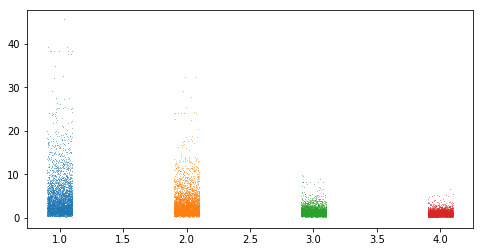

Delaware
[[ 0.38399608  0.26249106  0.13217618  0.08986722]
 [23.72769868 14.42121576  4.04848175  1.86975432]]


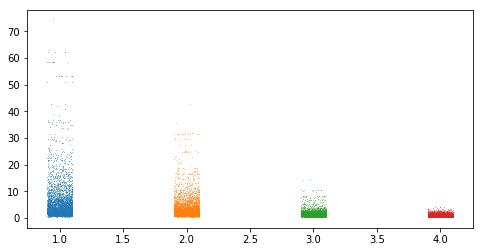

District of Columbia
[[ 0.03590147  0.04333459  0.04184546  0.03824849]
 [25.11034243 26.45206963 20.83811867 27.9236798 ]]


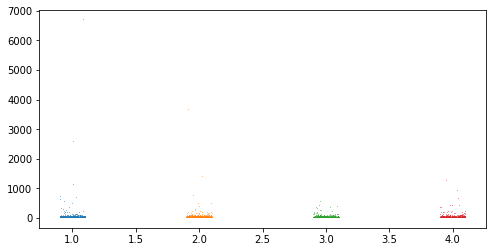

Florida
[[ 87.79643229  84.95080084   7.61913547   2.82914217]
 [182.9782196  175.29481991  15.85255596   6.02654406]]


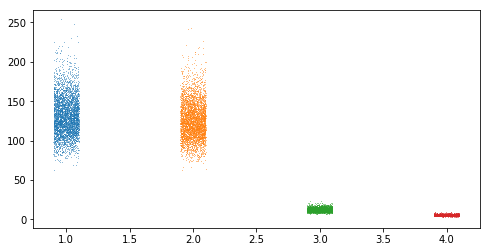

Georgia
[[ 1.39105631  1.59548047  0.24288649  0.10126778]
 [32.63192461 38.72673206  2.78369006  1.27481451]]


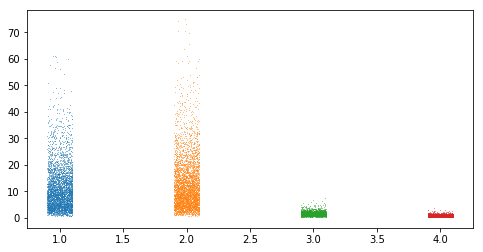

Hawaii
[[3.95841663e-02 3.68346394e-02 4.00837799e-02 2.75750191e-02]
 [2.63960997e+01 2.57822773e+01 2.24535635e+01 3.45070635e+01]]


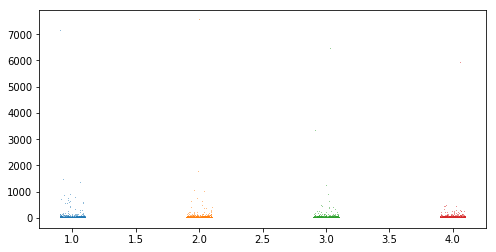

Idaho
[[ 0.27541501  0.32876759  0.13700278  0.09941157]
 [10.26863571 13.76572167  3.84671593  2.2246579 ]]


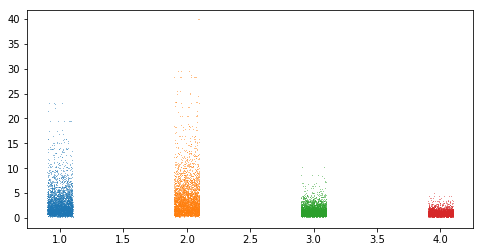

Illinois
[[ 24.23858002  16.98500041   2.56521626   0.78554429]
 [115.69482715  81.84921086  12.40963752   4.01624294]]


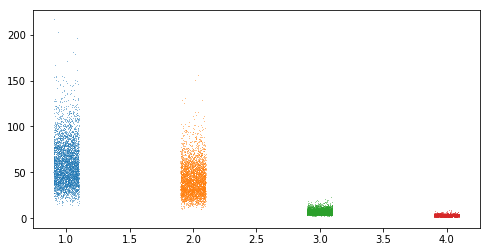

Indiana
[[ 0.32203206  0.33341565  0.14017555  0.09459214]
 [11.55025069 13.64499177  3.48498192  2.06450516]]


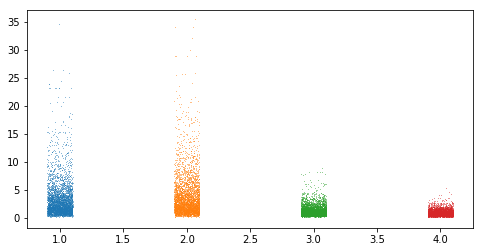

Iowa
[[ 26.09902658  28.29086395   4.14776897   1.39593775]
 [116.99031042 125.93615672  19.01007808   6.22546918]]


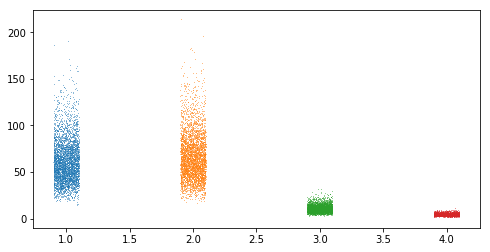

Kansas
[[  2.6697565    3.57087371   0.66924233   0.28771764]
 [103.34446766 139.7189639   21.73241017   5.02336989]]


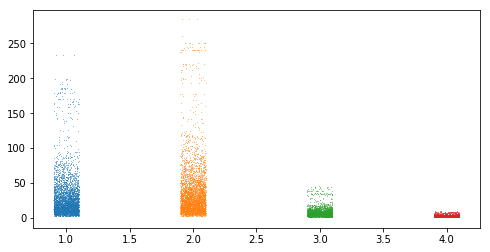

Kentucky
[[1.23647513e+00 1.63376687e+00 1.73507652e-01 1.76545954e-01]
 [1.93426457e+02 2.68674289e+02 7.13324477e+00 9.17744816e+00]]


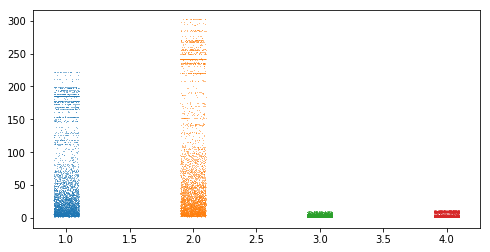

Louisiana
[[ 5.11319063  7.04786514  0.76669579  0.3680796 ]
 [66.84109109 91.54774659  8.72874409  3.29485536]]


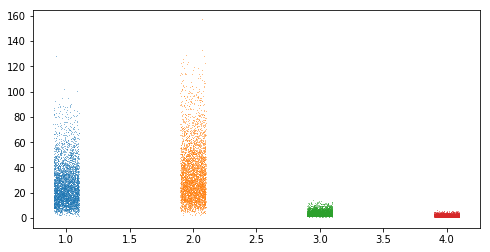

Maine
[[ 38.22660319  33.32662796   8.20196856   3.10574987]
 [196.24497888 169.13371153  43.04947     15.87877814]]


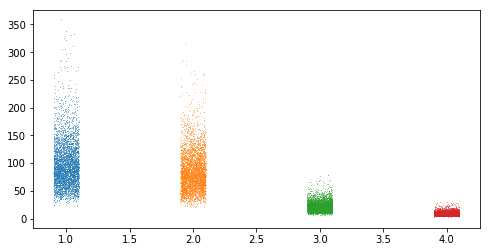

Maryland
[[  1.7169786    0.79122096   0.27322312   0.18074073]
 [110.06218037  48.68552494   9.24002305   3.4325879 ]]


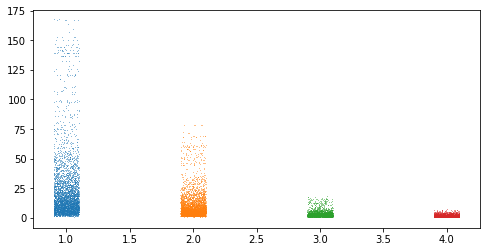

Massachusetts
[[ 24.12931936  12.83880137   3.4161795    1.50408293]
 [179.00378564  95.61802925  25.24567106  10.83859294]]


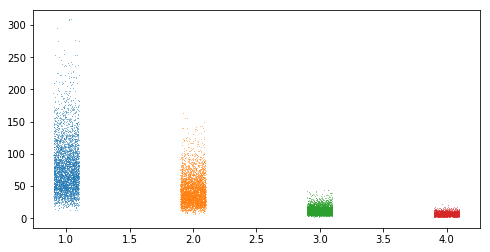

Michigan
[[42.5172594  36.30309696  5.75078987  2.32581496]
 [97.08753655 84.21683415 13.61333722  5.37687619]]


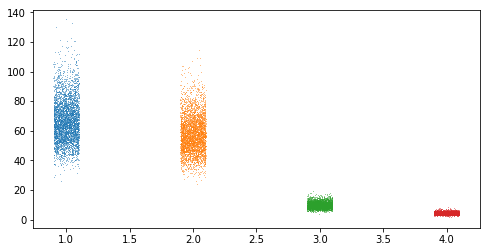

Minnesota
[[ 12.77295409  10.74353027   1.59184736   0.62526503]
 [230.20036291 191.80265102  28.50571998   9.18673605]]


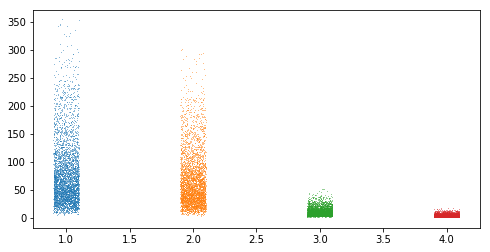

Mississippi
[[ 0.03569364  0.04248256  0.03447347  0.04568398]
 [21.9339737  30.1450285  23.93079315 21.3823139 ]]


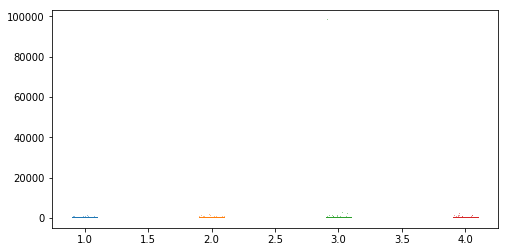

Missouri
[[ 48.10153028  59.69871183   5.8675095    2.28276374]
 [165.4365027  205.99045073  20.48550095   7.95315767]]


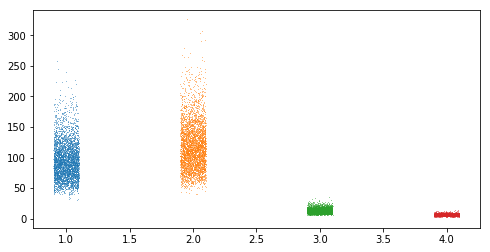

Montana
[[ 0.26134707  0.37317136  0.13531398  0.08975695]
 [11.70383323 19.19657278  3.63198862  1.95629493]]


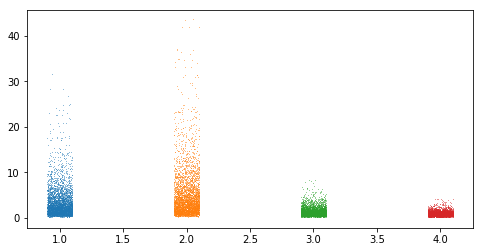

Nebraska
[[ 0.24638858  0.4185181   0.12740634  0.07434623]
 [11.52707993 21.88731452  3.54086501  1.6467466 ]]


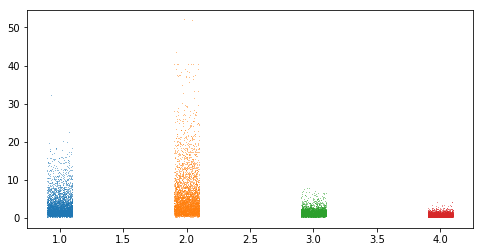

Nevada
[[15.65765525 15.80077864  1.83461265  0.6290719 ]
 [78.07286299 79.85182687  9.45383704  3.26357351]]


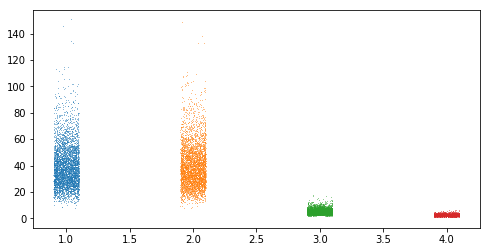

New Hampshire
[[36.36661269 32.2170279   6.49296118  1.98416954]
 [86.25167172 78.45306927 15.75428341  4.94535739]]


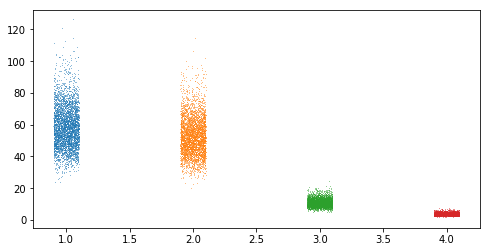

New Jersey
[[ 5.52134612  4.09827708  0.6977142   0.44267282]
 [71.11411928 54.00499447  7.16949158  4.05878302]]


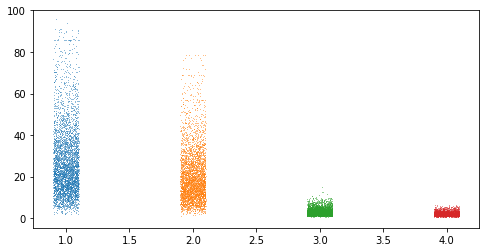

New Mexico
[[ 9.01522528  7.84371257  2.32630095  0.54930785]
 [49.12978965 42.50642788 12.48806326  2.54174607]]


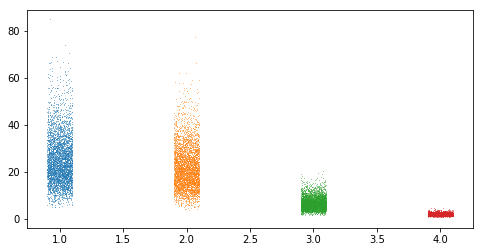

New York
[[  8.23602907   4.83526263   0.99755124   0.63840628]
 [141.37045736  88.05191241  16.21210281   8.24230205]]


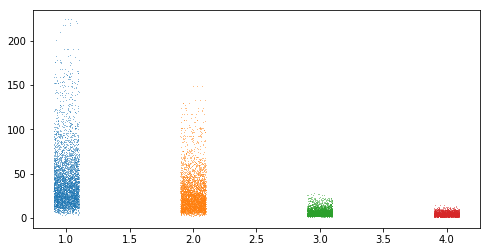

North Carolina
[[13.3328549  12.92583159  1.6300671   0.19015715]
 [67.56996193 64.53812747  8.29026871  1.14952887]]


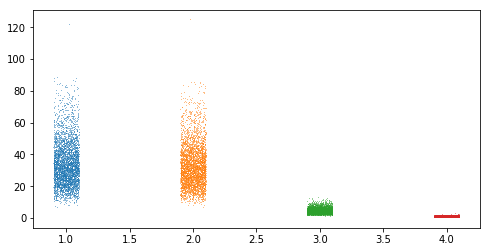

North Dakota
[[ 0.33335492  0.37206292  0.15131156  0.07968454]
 [14.10829555 20.02389445  4.09935927  1.6479846 ]]


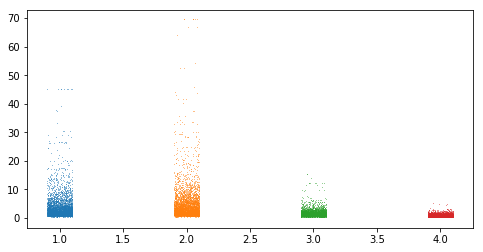

Ohio
[[ 51.72637126  52.51180447   7.29001512   2.3605492 ]
 [122.00952787 123.688051    17.92266118   5.72246143]]


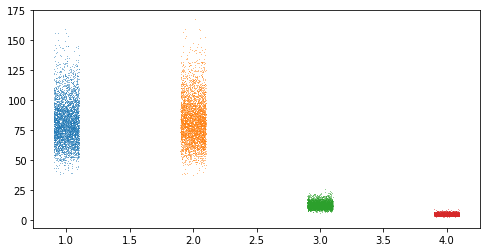

Oklahoma
[[ 0.0467213   0.0476332   0.03909465  0.04544567]
 [27.26317229 24.86120252 25.72784919 26.11515385]]


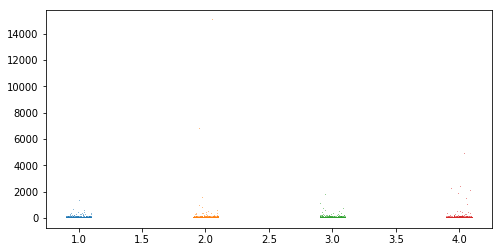

Oregon
[[ 17.37185473  13.02080772   2.82458303   1.50060529]
 [118.77160154  90.21772176  19.8667095   10.1587027 ]]


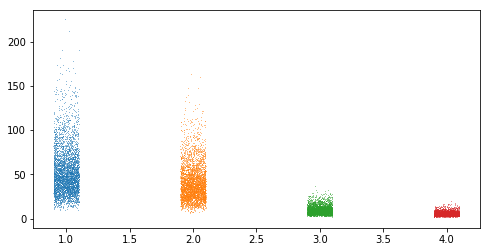

Pennsylvania
[[ 57.29667264  50.83856776   6.48272051   2.63363872]
 [128.84645059 114.19479989  14.52624645   6.10660464]]


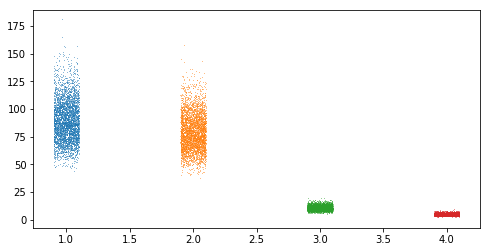

Rhode Island
[[ 0.98936838  0.74756634  0.27270091  0.23539074]
 [28.96642027 22.55895744  4.3053249   3.31029545]]


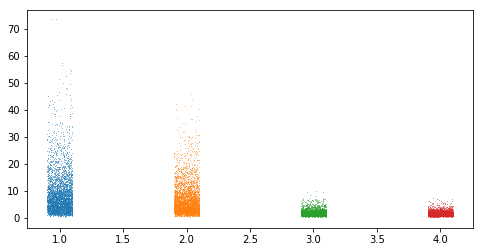

South Carolina
[[ 0.84320193  1.00166753  0.21665969  0.15887607]
 [34.62928045 41.54857695  3.8793247   2.19856573]]


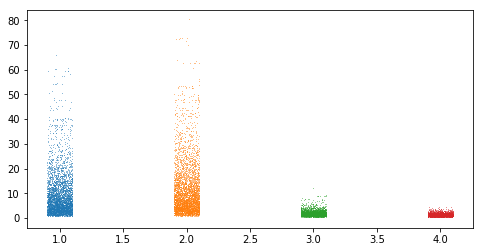

South Dakota
[[ 0.03430097  0.04555082  0.04040387  0.03904226]
 [26.46290922 21.37945027 25.88501266 26.1544208 ]]


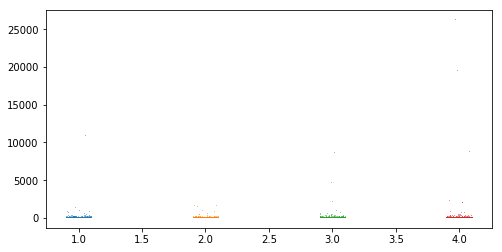

Tennessee
[[  2.71354664   3.75424159   0.62751088   0.27533352]
 [102.69535644 132.74603199  17.06174087   4.65105583]]


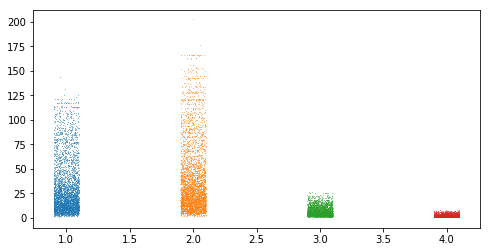

Texas
[[14.64490754 17.08123114  2.09522547  0.68101001]
 [57.93252506 67.56470379  8.33282569  2.76828876]]


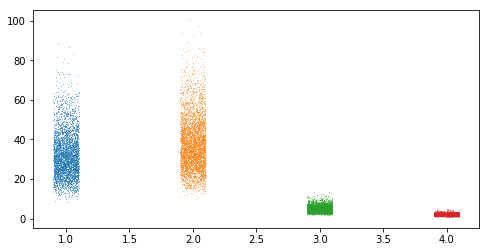

Utah
[[11.04998019 14.43828844  2.76373502  0.53618584]
 [35.06337495 46.36940099  9.01886133  1.82330914]]


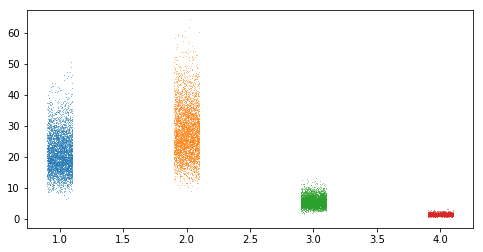

Vermont
[[ 4.9977826   2.17244648  0.79849016  0.54152922]
 [57.68388384 26.48247697  8.22764428  5.13902217]]


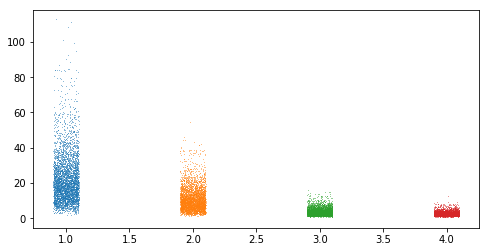

Virginia
[[ 41.57479352  34.62807713   5.91027094   1.34827707]
 [101.20860302  85.14056746  14.38226744   3.37086879]]


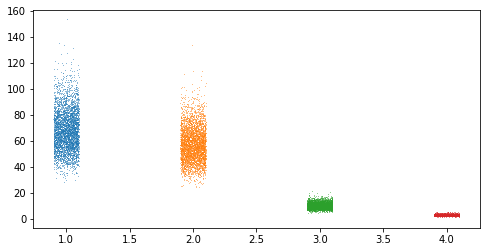

Washington
[[ 3.96481953  2.92754765  0.62231196  0.43776381]
 [29.8760953  22.09623192  4.28190889  2.6410507 ]]


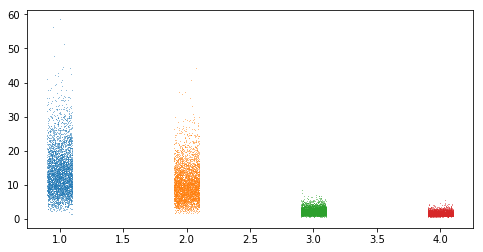

West Virginia
[[ 0.04288542  0.04749731  0.04263964  0.03231327]
 [27.97376896 25.1519764  22.81768605 26.14446064]]


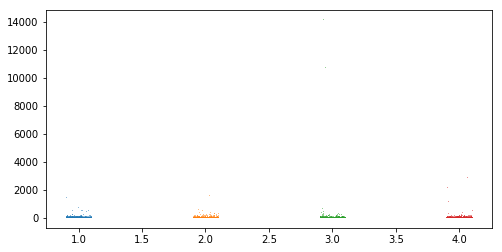

Wisconsin
[[21.610267   18.7907745   2.92305144  1.03360356]
 [83.74071924 71.95585972 11.43847686  3.85704316]]


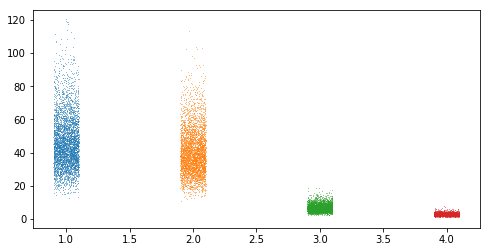

Wyoming
[[ 0.62564836  1.47826462  0.38891635  0.1879286 ]
 [17.16964312 50.06014187  8.35248141  2.51490804]]


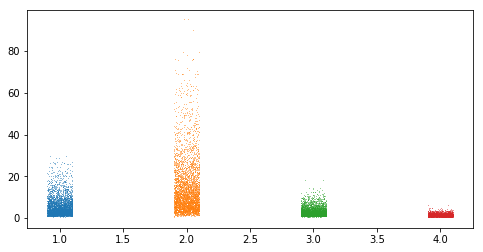

In [4]:
# Sample results for all states

print('Posterior α samples and 95% confidence intervals for each state\n')

results = {}
for state in states:
    data = {
        'S': survey_results[state].shape[0],
        'C': 4,
        'survey_results': survey_results[state],
        'cauchy_location': 0,
        'cauchy_scale': 1}
    results[state] = stan_model.sampling(data=data)
    samples = results[state].extract()

    print(state)
    print(np.percentile(samples['alpha'], [2.5, 97.5], axis=0))
    plt.figure(figsize=(8,4))
    for i in range(4):
        plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=4000), samples['alpha'][:,i], ',', alpha=0.5)
    plt.show()

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ — the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


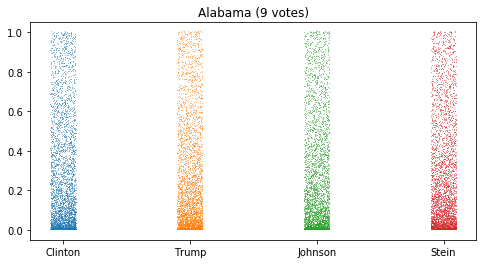

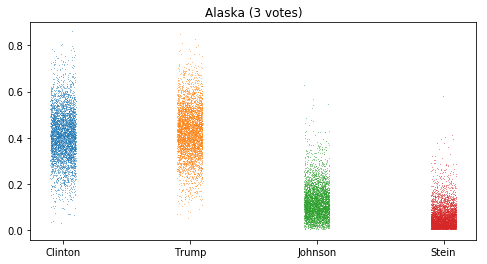

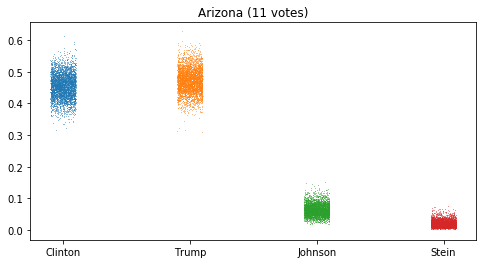

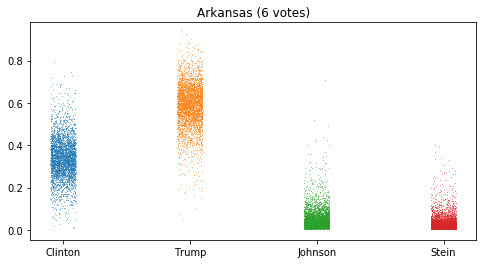

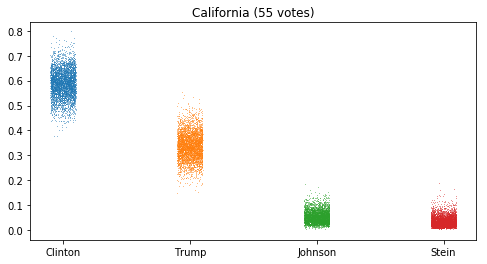

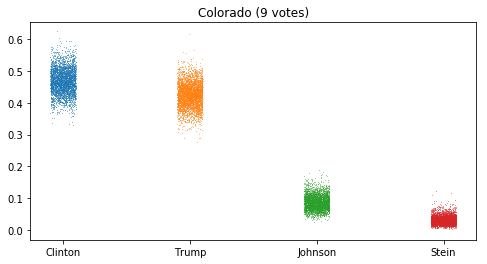

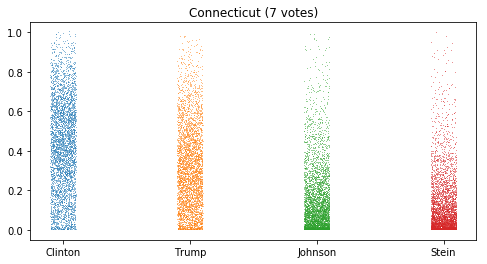

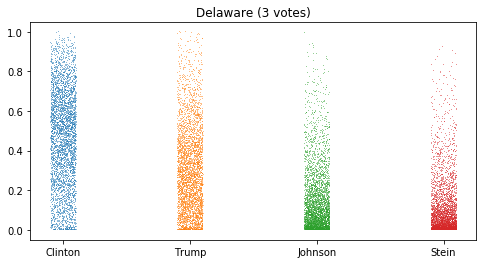

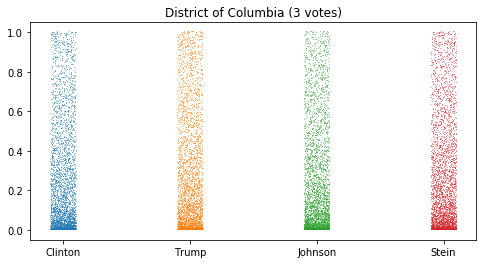

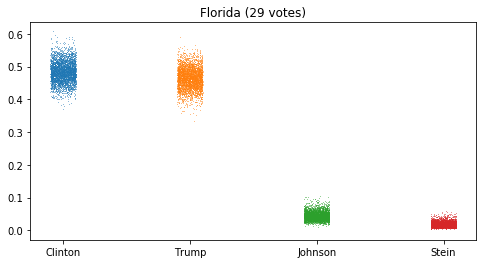

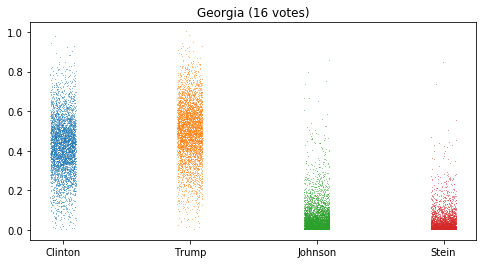

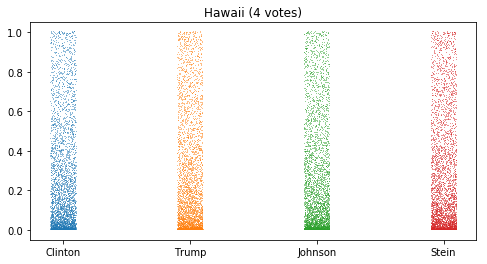

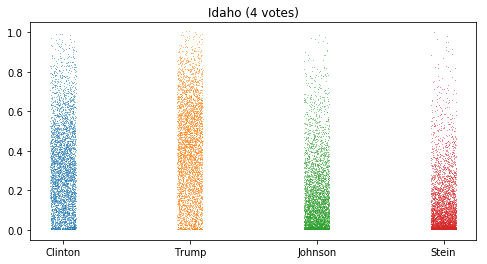

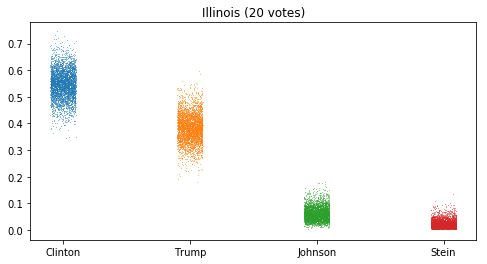

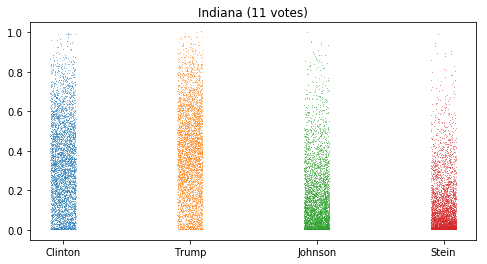

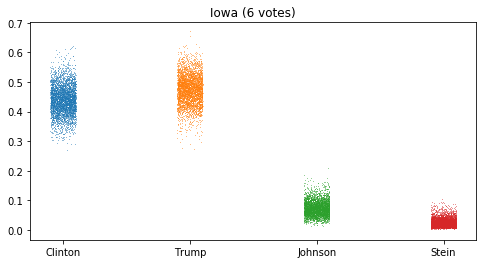

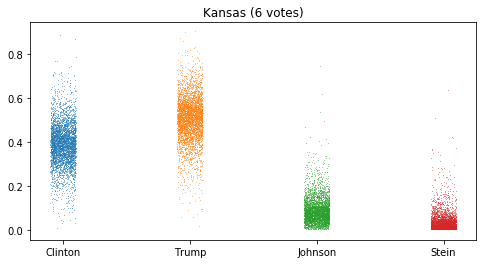

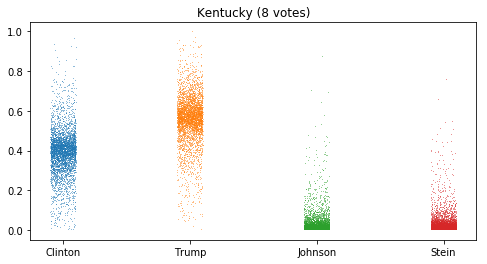

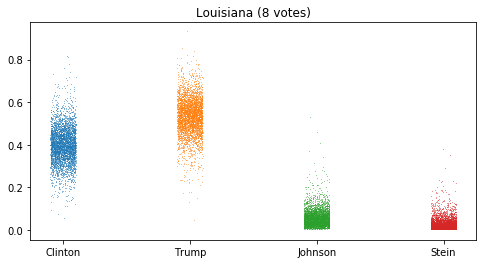

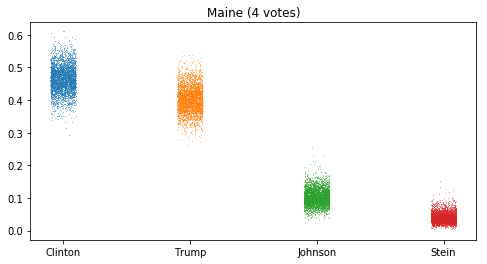

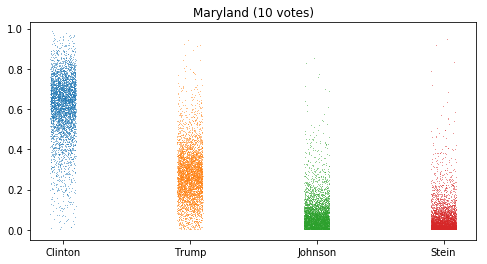

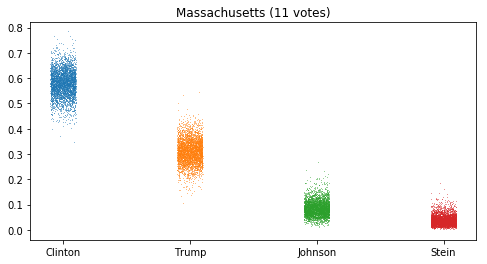

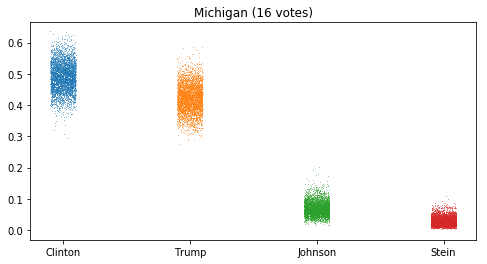

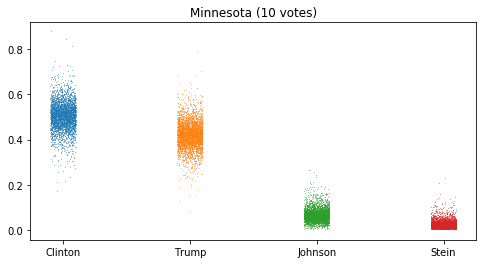

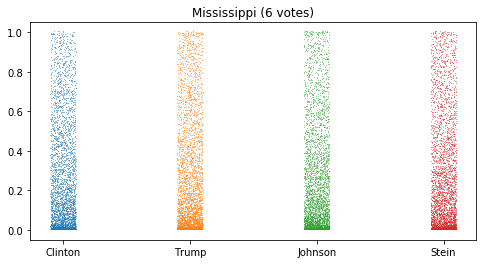

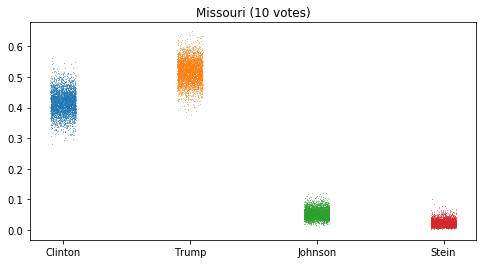

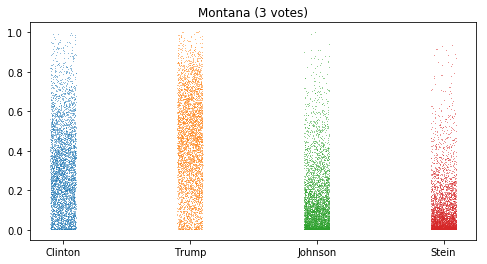

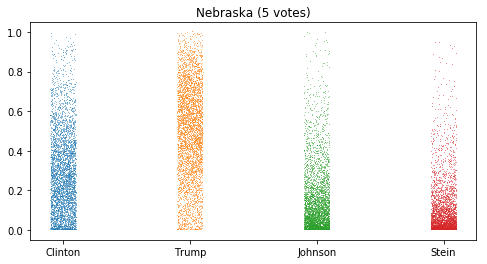

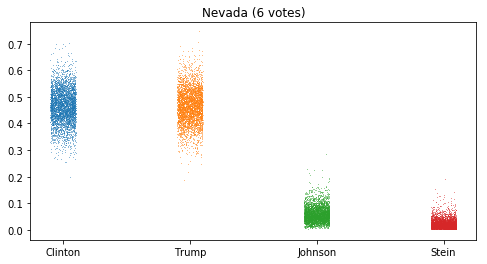

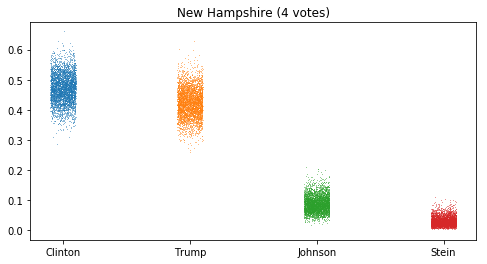

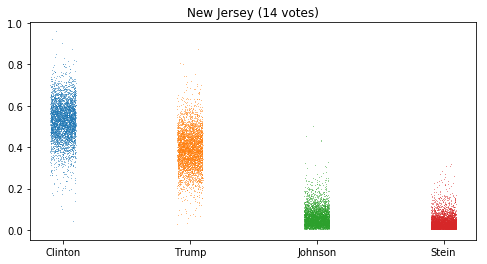

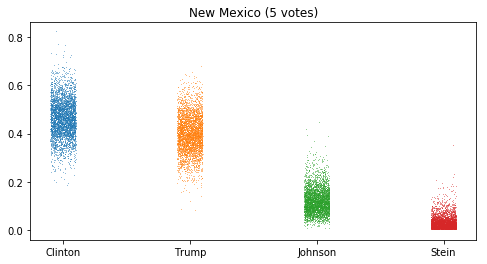

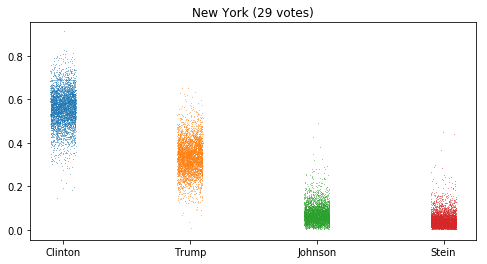

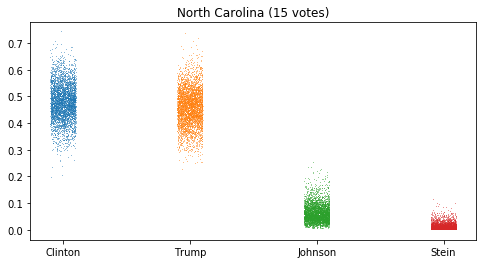

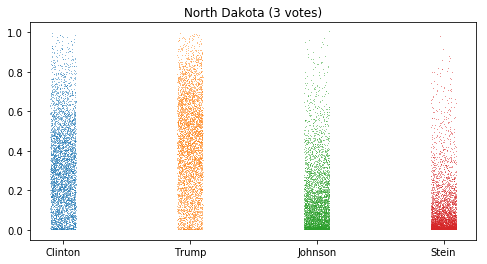

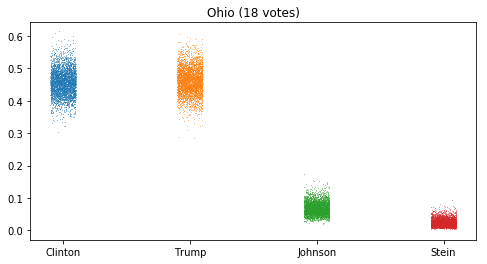

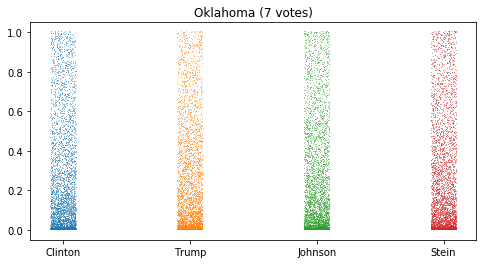

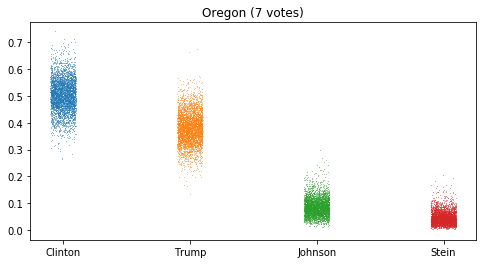

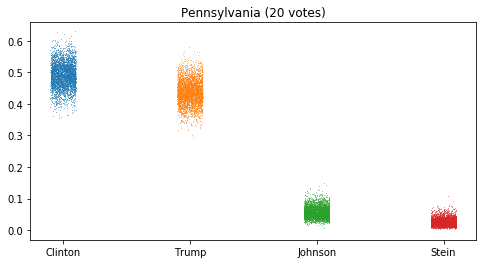

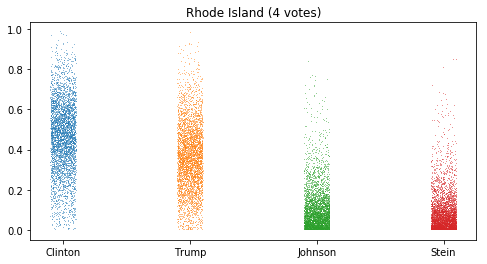

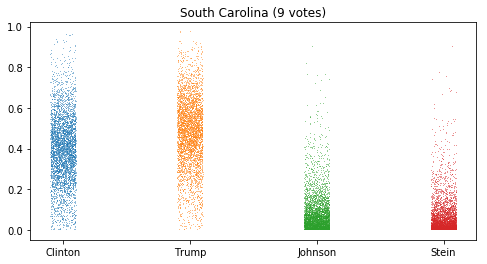

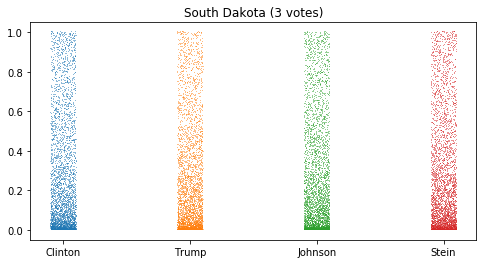

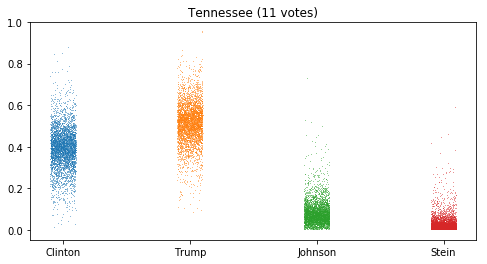

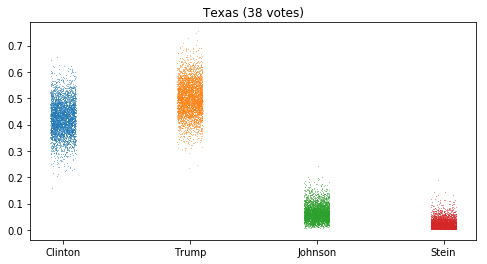

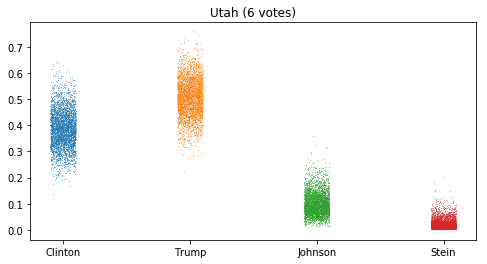

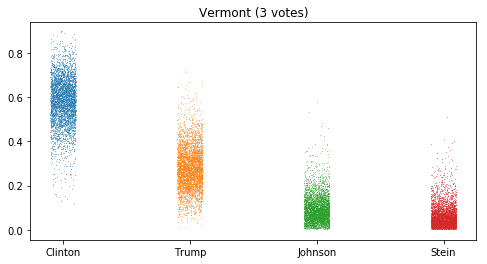

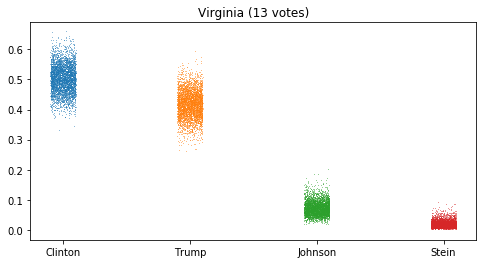

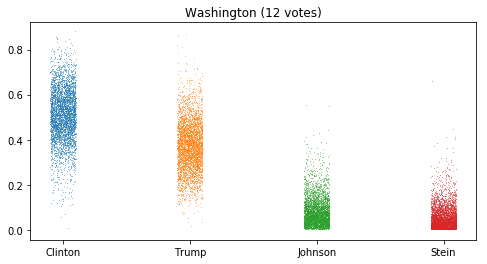

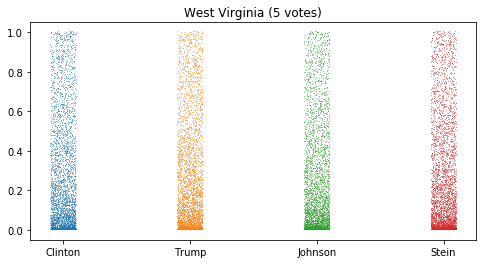

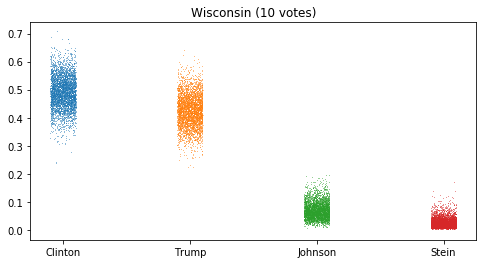

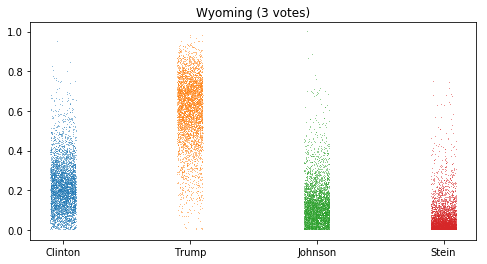

In [5]:
# Generating predictive samples using SciPy
for state in states:
    samples = results[state].extract()
    alpha = samples['alpha']
    p_predicted = np.empty(alpha.shape)
    for i in range(alpha.shape[0]):
        p_predicted[i] = stats.dirichlet.rvs(alpha[i])
    plt.figure(figsize=(8, 4))
    for i in range(4):
        plt.plot(stats.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), p_predicted[:,i], ',', alpha=0.5)
    plt.title(state + ' (' + str(electoral_votes[state]) + ' votes)')
    plt.xticks([0, 1, 2, 3], ['Clinton', 'Trump', 'Johnson', 'Stein'])
plt.show()

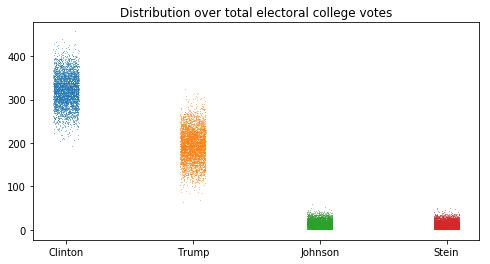

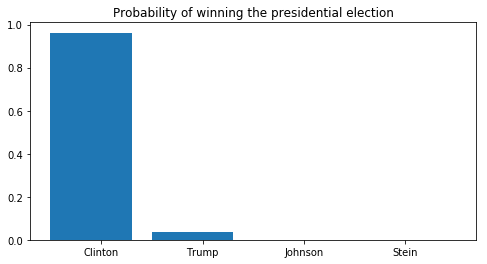

In [6]:
# Generating winner simulation using SciPy
samples = {state: results[state].extract() for state in states}
total_votes = np.zeros((4000, 4))
overall_winner = np.zeros(4000)
for s in range(4000):
    for state in states:
        alpha = samples[state]['alpha'][s]
        p_predicted = stats.dirichlet.rvs(alpha)
        winner = p_predicted.argmax()
        total_votes[s, winner] += electoral_votes[state]
    overall_winner[s] = total_votes[s].argmax()

plt.figure(figsize=(8, 4))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), total_votes[:,i], ',', alpha=0.5)
plt.xticks([0, 1, 2, 3], ['Clinton', 'Trump', 'Johnson', 'Stein'])
plt.title('Distribution over total electoral college votes')

plt.figure(figsize=(8, 4))
plt.hist(overall_winner, bins=[-0.5, 0.5, 1.5, 2.5, 3.5], width=0.8, align='mid', density=True)
plt.xticks([0, 1, 2, 3], ['Clinton', 'Trump', 'Johnson', 'Stein'])
plt.title('Probability of winning the presidential election')
plt.show()